In [2]:
# ИСТОЧНИК: КУРС STEPIC - "Введение в DS и ML" 
# Исходные данные - "train.csv" - пассажиры Титаника

In [25]:
# Импортируем все что может быть полезно

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, confusion_matrix
import numpy as np
from sklearn.ensemble import RandomForestClassifier


In [4]:
# Импортирую блок для корректной визуализации дерева
# pip install graphviz - установка пакета
from IPython.display import SVG
from graphviz import Source
from IPython.display import display 
from IPython.display import HTML

style = "<style>svg{width:30% !important; height:10% !important;}</style>"
HTML(style)

In [5]:
# Читаем данные из файла

data = pd.read_csv("train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Выделяем в данные X и y

X = data.drop(['Survived','Name','PassengerId','Ticket','Cabin'], axis=1)
y = data['Survived']
X = pd.get_dummies(X)
X = X.fillna({'Age':X.Age.median()})

# Для дерева решений необходимо оставлять только числовые переменные
# Удаляем ненужные данные методом drop
# Переводим в числа категориальные переменные методом get_dummies
# Заменяем пустые значения методом fillna. 
# Для простоты пропущенное значение заменяется медианным, но есть варианты намаинить пропущенные значения

In [7]:
# Создаем модель дерева. 

clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X,y)          

DecisionTreeClassifier(criterion='entropy')

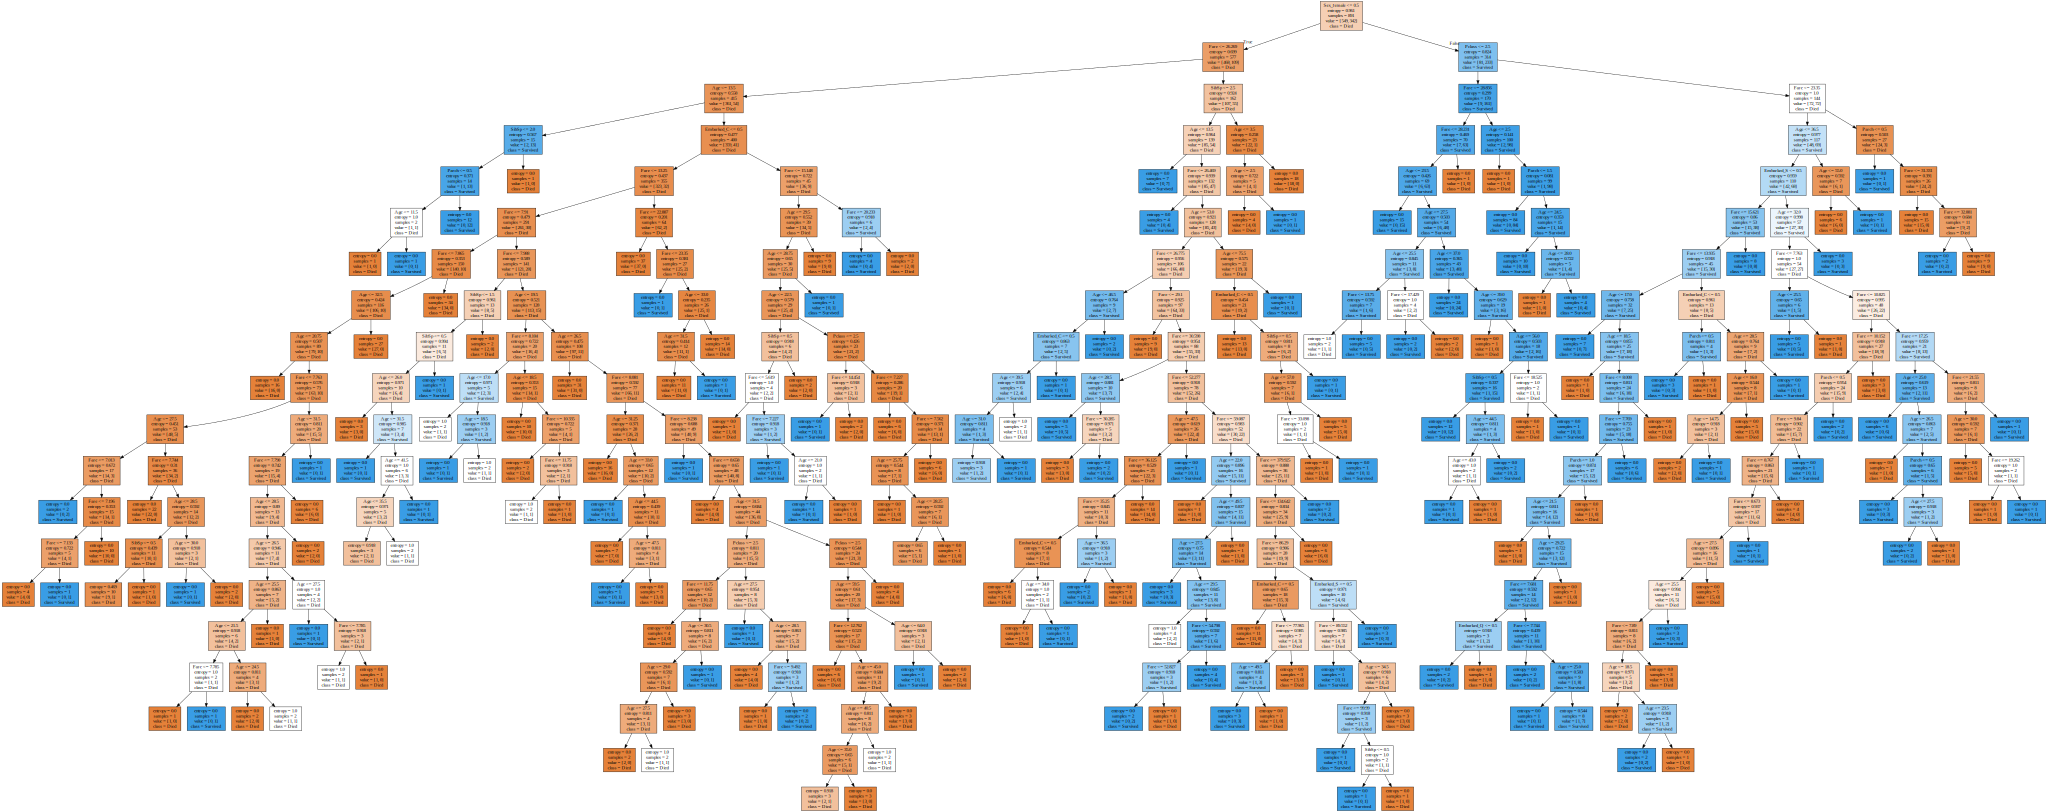

In [8]:
# Визуализация дерева

graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(X), class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

# Самая элементарная модель возможного дерева без точечных настроек. 
# Однако при неограниченный настройках дерево имеет тенденцию разрастаться на реальных данных
# Необходимо разбивать выгрузку на тестовую и обучающую, провести кроссвалидацию


In [10]:
# Модель показывает высокий score - но на имеющихся данных

clf.score(X,y)

0.9797979797979798

In [11]:
# Разделим данные на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
clf.fit(X_train,y_train)
score_train = clf.score(X_train,y_train)
score_test = clf.score(X_test,y_test)
print(f'Тренировочная - {score_train}, Тестовая - {score_test}')

# Модель переобучилась - так как нашла слишком много частных закономерностей в обущающей выборке

Тренировочная - 0.9798657718120806, Тестовая - 0.7728813559322034


In [11]:
# Улучшим модель 
# Будем наращивать максимальную глубину дерева и смотреть как изменяется score

In [12]:
max_depth_values = range(1,100) #в диапозоне от 1 до 100
score_data = pd.DataFrame()   #создаем dataframe, куда будем помещать результаты
for max_depth in max_depth_values: #цикл тренирует модель для каждой максимальной длины
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score]})
    score_data = score_data.append(temp_score_data) #в датафрейм добавляется score для тренировояных данных и теста
    

In [13]:
# В таком виде не удобно визуализировать данные
score_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.810169


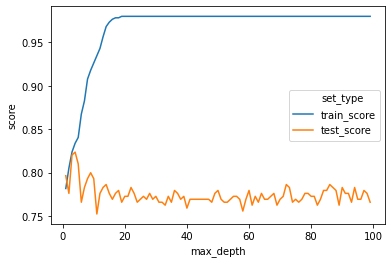

In [14]:
# С помощью метода melt меняем формат dataframe и теперь его можно визуализировать в lineplot

scores_data_long = pd.melt(score_data, id_vars = ['max_depth'], value_vars = ['train_score','test_score'], var_name = 'set_type', value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [15]:
# Для точности этого недостаточно и необходима кроссвалидация
# Для этого используем метод cross_val_score (cv - количество делений выборки при валидации - выбираем сами)
# и добляем его в цикл

for max_depth in max_depth_values: 
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 
                                    'test_score': [test_score], 'cross_score': [mean_cross_val_score]})
    score_data = score_data.append(temp_score_data) 


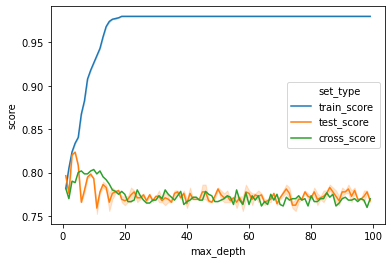

In [16]:
scores_data_long = pd.melt(score_data, id_vars = ['max_depth'], value_vars = ['train_score','test_score','cross_score'], var_name = 'set_type', value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [17]:
# Для автоматизации всего процесса используем GridSearchCV - метод для оптимизации машинного обучения
# Можно использовать метод RandomizedSearchCV - работает аналогично, но приближенно, и следовательно быстрее
clf = tree.DecisionTreeClassifier() #создаем пустую модель
parametrs = {'criterion':['gini','entropy'], 'max_depth':range(1,50)} #создаем словарь с возможными значениями критериев
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5) #создаем такую модельку
grid_search_cv_clf.fit(X_train, y_train) #так же тренируем ее

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 50)})

In [18]:
# Метод best_params_ позволяет получить лучшие значения для каждого параметра модели

grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 6}

In [19]:
#Сохраняем лучшйю модель с помощью метода best_clf и учим ее

best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

0.7694915254237288

In [20]:
# Предсказываем y с помощью метода predict и теперь мы пожем посмотреть более информативные метрики - точность и полноту

y_pred = best_clf.predict(X_test)
prec = precision_score(y_test,y_pred)
recal = recall_score(y_test,y_pred)
print(f'Точность - {prec} полнота - {recal}')

Точность - 0.8023255813953488 полнота - 0.575


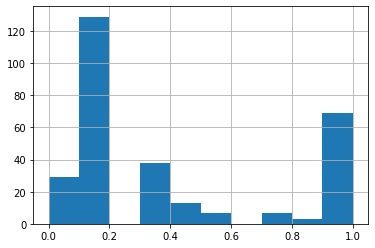

In [21]:
# Также нужно помнить о том, что именно скрывается за предсказанием
# Дерево решений не может просто отнести наблюдение к одноу или другому классу
# Оно находит вероятности этих отнесений, но в у_pred - попадают уже предсказания
# Иными словами y_pred - хранит в себе нули и единицы, но дерево считает вероятности
# Их можно достать и посмотреть
# Сохраняем вероятности в переменную y_predicted_prob с помощью метода predict_proba

y_predicted_prob = best_clf.predict_proba(X_test) 
pd.Series(y_predicted_prob [:,1]).hist() #выводим в гистограмму

# По умолчанию граница вероятности - 0,5, 
# то есть если для наблюдения вероятность  0,4 - ему будет предсказан 0, а для вероятности 0,8 - будет предсказан 1
# Это можно изменить, если есть такая потребность

In [22]:
# Воспользуемся библиотекой numpy и методом where
# Этот метод по аналогии с формулой если в excel
# Здесь мы относим у единицу все, что больше 0,2
# Делаем новое предсказание и видим как меняются метрики - precision падает, а recall растет
# То есть больше вероятности совершить ошибку второго рода и меньше - совершить ошибку первого рода

y_pred = np.where(y_predicted_prob[:,1]>0.2, 1, 0)
prec = precision_score(y_test,y_pred)
recal = recall_score(y_test,y_pred)
print(f'Точность - {prec} полнота - {recal}')

Точность - 0.7372262773722628 полнота - 0.8416666666666667


In [23]:
# Вывести матрицу. В данном случае TP=143; FP=32; FN=20; TN=100
confusion_matrix(y_test,y_pred)

array([[139,  36],
       [ 19, 101]], dtype=int64)

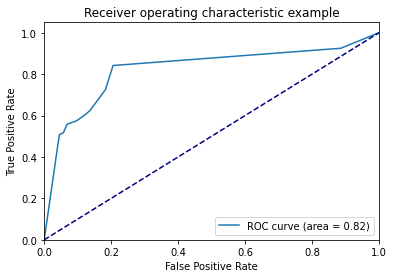

In [24]:
# #Для наглядности строим ROC-кривую
# На этой кривой мы можем видет какие значение порога нас устроят
# Здесь мы видем долю точности

fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Другие параметры дерева:
    
    1) min_samples_leaf – минимальное число объектов в листе. 
    У этого параметра есть понятная интерпретация: скажем, если он равен 5, 
    то дерево будет порождать только те классифицирующие правила, которые верны как минимум для 5 объектов
    2) min_impurity_decrease - Узел будет разделен, если это разделение вызовет уменьшение примеси 
    больше или равное этому значению. 
    3) min_samples_split - минимальное число объектов в выборке для разделения, что бы разделение произошло

    Есть и  другие параметры - смотри документацию 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# Случайный лес

Дерево является очень склонной к переобучению моделью - оно стремиться выявлять частные закономерности
Если взять несколько деревьев и каждому из них показать только часть данных, каждое дерево найдет частные закономерности
Усредненное предсказание частных деревьев даст хороший результат для всех данных
Такая модель называется случайным лесом

In [27]:
# n_estimators - число деревьев в лесу

clf_rf = RandomForestClassifier()
parametrs = {'n_estimators': [10,20,30], 'max_depth': [2,5,7,10]}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 20}

In [28]:
# Лес позволяет показать важность каждой из фичей с помощью метода feature_importances_

best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train),
                                    'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
5,Sex_female,0.239408
6,Sex_male,0.172720
4,Fare,0.167173
1,Age,0.152151
0,Pclass,0.119760
2,SibSp,0.051445
3,Parch,0.042670
7,Embarked_C,0.025447
9,Embarked_S,0.019320
8,Embarked_Q,0.009905
